### Initial descriptive stats and exploratory data analysis

The data to be explored is telephone interpreter data which contains information such as
company, call duration, hold time (before being connected to call), language (from), and date
The following code is an example of my exploratory data analysis work flow and documentation
This is a fictional data set and non-exhaustive analysis.

### IMPORTING DATA FROM SQL DATABASE 

In [8]:
# connecting to the database
# Import create_engine
from sqlalchemy import create_engine, Table, MetaData
import psycopg2

# Import csv for writing output to csv files
import csv

# Create an engine that connects to the census.sqlite file: engine
engine = create_engine('postgresql+psycopg2://user:password'
					   '@bleebleblabble.ccmzie7d1ii4.us-east-1.rds.amazonaws.com:5432/analyst_project')

# Print table names
print(engine.table_names())

['call_data', 'companies', 'services']


In [9]:
# Reflect call_data table from the engine
metadata = MetaData()
call_data = Table('call_data', metadata, autoload=True, autoload_with=engine)

# Print call_data table metadata
print(repr(call_data))
print()

# Print the column names
print(call_data.columns.keys())
print()

# Print full table metadata
print(repr(metadata.tables['call_data']))

Table('call_data', MetaData(bind=None), Column('id', BIGINT(), table=<call_data>, primary_key=True, nullable=False, server_default=DefaultClause(<sqlalchemy.sql.elements.TextClause object at 0x0000003F6F9FB9B0>, for_update=False)), Column('call_start', TIMESTAMP(timezone=True), table=<call_data>), Column('language', VARCHAR(length=200), table=<call_data>), Column('company_name', VARCHAR(length=200), table=<call_data>), Column('patient_name', VARCHAR(length=200), table=<call_data>), Column('interpreter_hold_time', INTEGER(), table=<call_data>), Column('duration', INTEGER(), table=<call_data>), Column('department', VARCHAR(length=200), table=<call_data>), schema=None)

['id', 'call_start', 'language', 'company_name', 'patient_name', 'interpreter_hold_time', 'duration', 'department']

Table('call_data', MetaData(bind=None), Column('id', BIGINT(), table=<call_data>, primary_key=True, nullable=False, server_default=DefaultClause(<sqlalchemy.sql.elements.TextClause object at 0x0000003F6F9FB9

In [10]:
# connect to the engine
connection = engine.connect()

In [11]:
# first query setup (3D.i)

headers1 = ['Company_Name', 'Cummulative_Duration', 'Average_Hold_Time', 'Day']

query1 = 'SELECT company_name, SUM(duration) AS cummulative_duration, \
AVG(interpreter_hold_time) AS average_hold_time, call_start::date AS date \
FROM call_data \
GROUP BY company_name, call_start::date \
ORDER BY company_name, call_start::date'

In [14]:
# first query save results
results1 = connection.execute(query1).fetchall()

# save results to csv
with open("C:\\Users\\name\\call_data.csv", 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers1)
    for row in results1:
        writer.writerow(row)

In [15]:
# second query setup (3D.ii)

headers2 = ['Language', 'Cummulative_Duration', 'Average_Hold_Time', 'Day']

query2 = 'SELECT language, SUM(duration) AS cummulative_duration, \
AVG(interpreter_hold_time) AS average_hold_time, call_start::date AS date \
FROM call_data \
GROUP BY language, call_start::date \
ORDER BY language, call_start::date'

In [16]:
# second query save results
results2 = connection.execute(query2).fetchall()

# save results to csv
with open("C:\\Users\\name\\call_data.csv", 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers2)
    for row in results2:
        try:
            writer.writerow(row)
        except:
            # Maori throws an error b/c of the macron
            # this is not the most elegant solution but still allows for proper indexing and saving
            writer.writerow([row[0].encode('utf-8'), row[1], row[2], row[3]])

In [17]:
# third query setup (3D.iii)

headers3 = ['Language', 'Cummulative_Duration', 'Average_Hold_Time', 'Day', 'Hour']

query3 = 'SELECT language, SUM(duration) AS cummulative_duration, \
AVG(interpreter_hold_time) AS average_hold_time, call_start::date AS date, \
date_trunc(\'hour\', call_start::time) AS hour_of_day \
FROM call_data \
GROUP BY language, call_start::date, date_trunc(\'hour\', call_start::time) \
ORDER BY language, call_start::date, date_trunc(\'hour\', call_start::time)'

In [18]:
# third query save results
results3 = connection.execute(query3).fetchall()

# save results to csv
with open("C:\\Users\\name\\call_data.csv", 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers3)
    for row in results3:
        try:
            writer.writerow(row)
        except:
            # Maori throws an error b/c of the macron
            # this is not the most elegant solution but still allows for proper indexing and saving
            writer.writerow([row[0].encode('utf-8'), row[1], row[2], row[3], row[4]])

In [19]:
connection.close

<bound method Connection.close of <sqlalchemy.engine.base.Connection object at 0x0000003F6F31BEB8>>

In [11]:
engine.dispose()

### VISUALIZATION AND INTERESTING METRICS

In [20]:
# results1.shape
# results1.describe()
# results1.info()

Generating 3Di scatter plots

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [27]:
results1 = pd.DataFrame(data=results1, columns=headers1)
results2 = pd.DataFrame(data=results2, columns=headers2)
results3 = pd.DataFrame(data=results3, columns=headers3)

# ensure datetime object for proper handling
results1["Day"] = pd.to_datetime(results1["Day"])

Text(0, 0.5, 'Average Hold Time (minutes)')

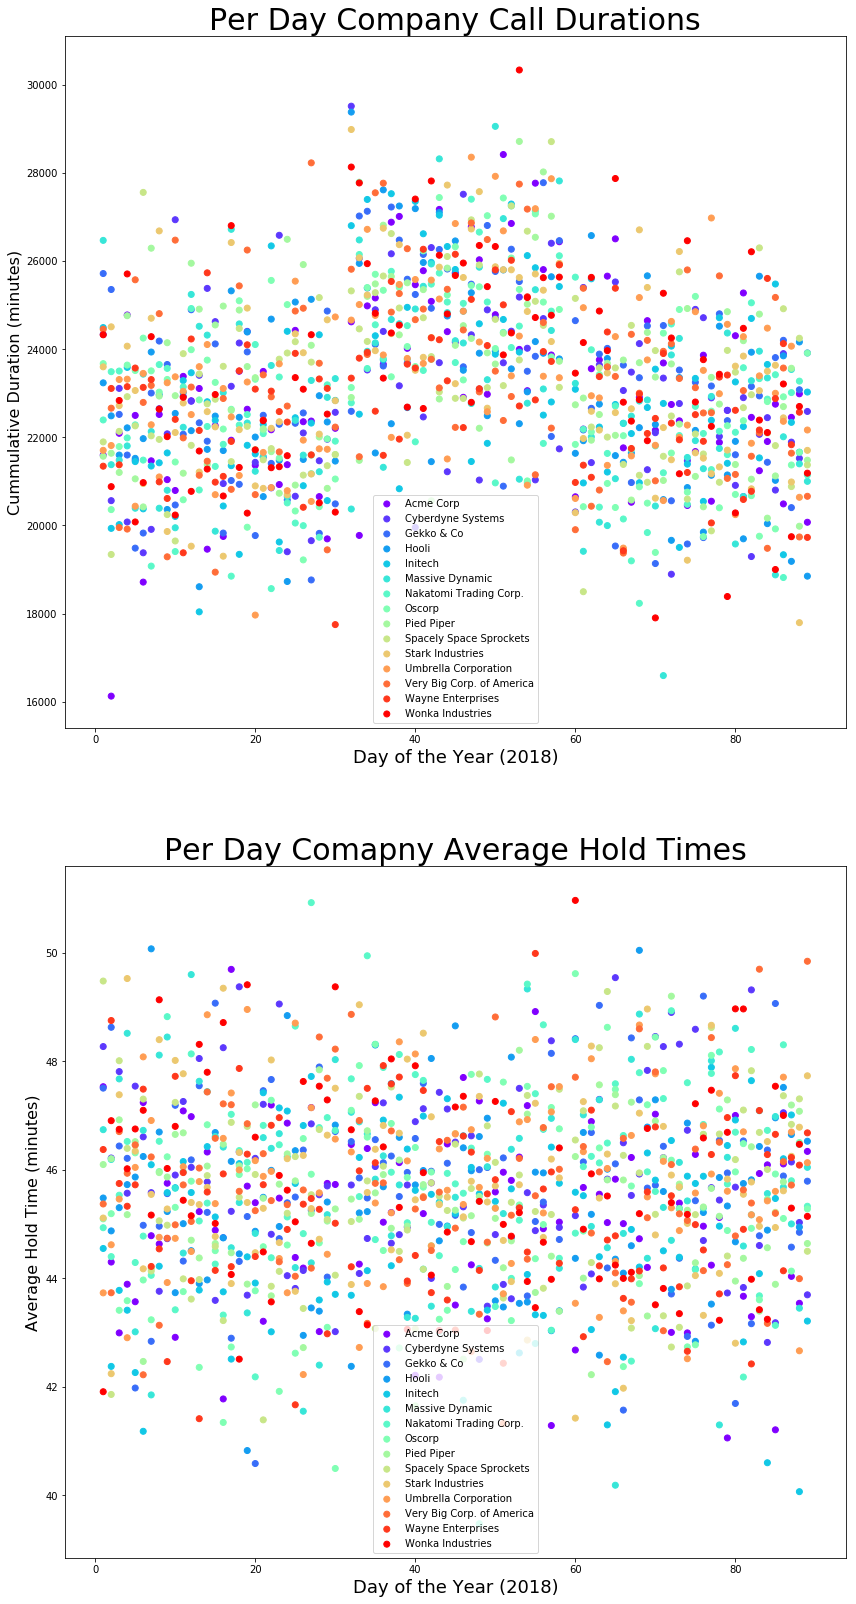

In [28]:
# create color palette to represent each company
color_range = list(range(0,results1['Company_Name'].nunique()))
color_keys = list(results1['Company_Name'].unique())

# convert color palette to pd.series that can be associated with each row
colormap = cm.rainbow
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 1, len(color_keys))]
color_dict = {}
for key, value in zip(color_keys, colorlist):
    color_dict[key] = value
color_list = [color_dict[company] for company in results1['Company_Name']]
results1['Color'] = pd.Series(color_list)

# Use a for-loop to generate scatter plot (this allows inclusion and proper formating of a legend)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 28))
for company in color_keys:
    per_company_results = results1[results1['Company_Name'] == company]
    ax1.scatter(x=per_company_results["Day"].dt.dayofyear, y=per_company_results['Cummulative_Duration'], c=per_company_results['Color'])
    ax2.scatter(x=per_company_results["Day"].dt.dayofyear, y=per_company_results['Average_Hold_Time'], c=per_company_results['Color'])


ax1.legend(loc='best', labels=color_keys)
ax1.set_title('Per Day Company Call Durations', fontsize=30)
ax1.set_xlabel('Day of the Year (2018)', fontsize=18)
ax1.set_ylabel('Cummulative Duration (minutes)', fontsize=16)

ax2.legend(loc='best', labels=color_keys)
ax2.set_title('Per Day Comapny Average Hold Times', fontsize=30)
ax2.set_xlabel('Day of the Year (2018)', fontsize=18)
ax2.set_ylabel('Average Hold Time (minutes)', fontsize=16)

The data covers the first three months of 2018. 
Without explicitly labeling the start/end of each month  there is a clear separation of monthly cummulative call duration
January and March saw similar total cummulative call valumes 
while the cluster of February cummulative call duration appears to be about 5000 minutes more/higher.
There is no apparent similar trend for average call duration.

Generate box plots per month to explicitly compare monthly differences.

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(results1[results1["Company_Name"]=='Hooli']["Day"].dt.dayofyear)

261     1
262     2
263     3
264     4
265     5
266     6
267     7
268     8
269     9
270    10
271    11
272    12
273    13
274    14
275    15
276    16
277    17
278    18
279    19
280    20
281    21
282    22
283    23
284    24
285    25
286    26
287    27
288    28
289    29
290    30
291    32
292    33
293    34
294    35
295    36
296    37
297    38
298    39
299    40
300    41
301    42
302    43
303    44
304    45
305    46
306    47
307    48
308    49
309    50
310    51
311    52
312    53
313    54
314    55
315    56
316    57
317    58
318    60
319    61
320    62
321    63
322    64
323    65
324    66
325    67
326    68
327    69
328    70
329    71
330    72
331    73
332    74
333    75
334    76
335    77
336    78
337    79
338    80
339    81
340    82
341    83
342    84
343    85
344    86
345    87
346    88
347    89
Name: Day, dtype: int64


### as suspected there are data points/rows missing which is why the months segregate so nicely
imputing the mean or median values by company would probably suffice for vizualization
or dropping altogether if modeling is pursued

In [16]:
# Split and prepare data for boxplot groups by month
month_list = [results1['Day'][i].month for i in range(len(results1['Day']))]
results1['Month'] = pd.Series(month_list).values

# create new dataframe where each column represents a language, the values are cummulative_duration, and the index is day
month_keys = results1['Month'].unique()
company_keys = results1['Company_Name']

# boxplots are easier to play with if data input as np.adarray
per_month_durations = [np.asarray(results1[results1['Month'] == month]['Cummulative_Duration']) for month in month_keys]
per_month_hold_times = [np.asarray(results1[results1['Month'] == month]['Average_Hold_Time']).astype(int) for month in month_keys]

Text(0, 0.5, 'Average Hold Time (minutes)')

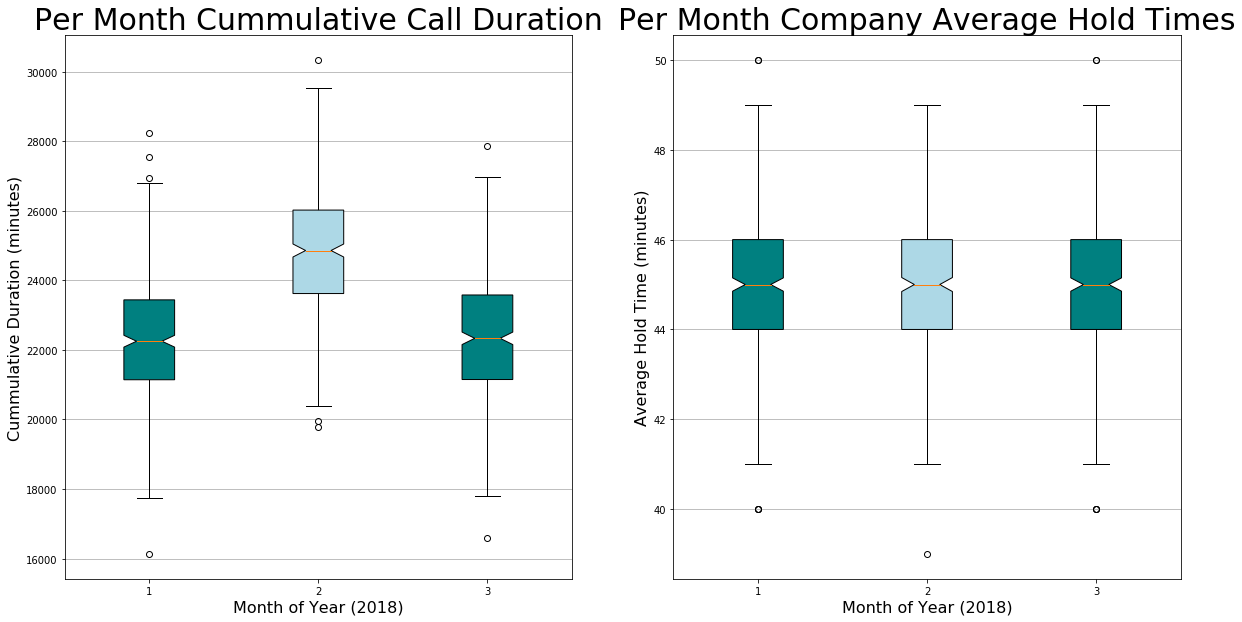

In [17]:
#Create figures and plot boxplots
fig2, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

bplot1 = ax1.boxplot(x=per_month_durations,
            positions=month_keys,
            notch=True, # add notch at 50%ile
            vert=True,   # vertical box aligmnent
            patch_artist=True)   # fill with color)

bplot2 = ax2.boxplot(x=per_month_hold_times,
            positions=month_keys,
            notch=True, # add notch at 50%ile
            vert=True,   # vertical box aligmnent
            patch_artist=True)   # fill with color)
    
# fill with colors
colors = ['teal', 'lightblue', 'teal']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

# adding horizontal grid lines and labeling chart
ax1.yaxis.grid(True)
ax1.set_title('Per Month Cummulative Call Duration', fontsize=30)
ax1.set_xlabel('Month of Year (2018)', fontsize=16)
ax1.set_ylabel('Cummulative Duration (minutes)', fontsize=16)

ax2.yaxis.grid(True)
ax2.set_title('Per Month Company Average Hold Times', fontsize=30)
ax2.set_xlabel('Month of Year (2018)', fontsize=16)
ax2.set_ylabel('Average Hold Time (minutes)', fontsize=16)

As expected a clear separation between the distributions exists between months of cummulative call duration.
The IQRs do not appear to overlap.
Either a student t-test or welch t-test may be appropriate to give this difference statistical significance.
Per Month company average hold times appear very uniform from month to month.

Text(0, 0.5, 'Average Hold Time (minutes)')

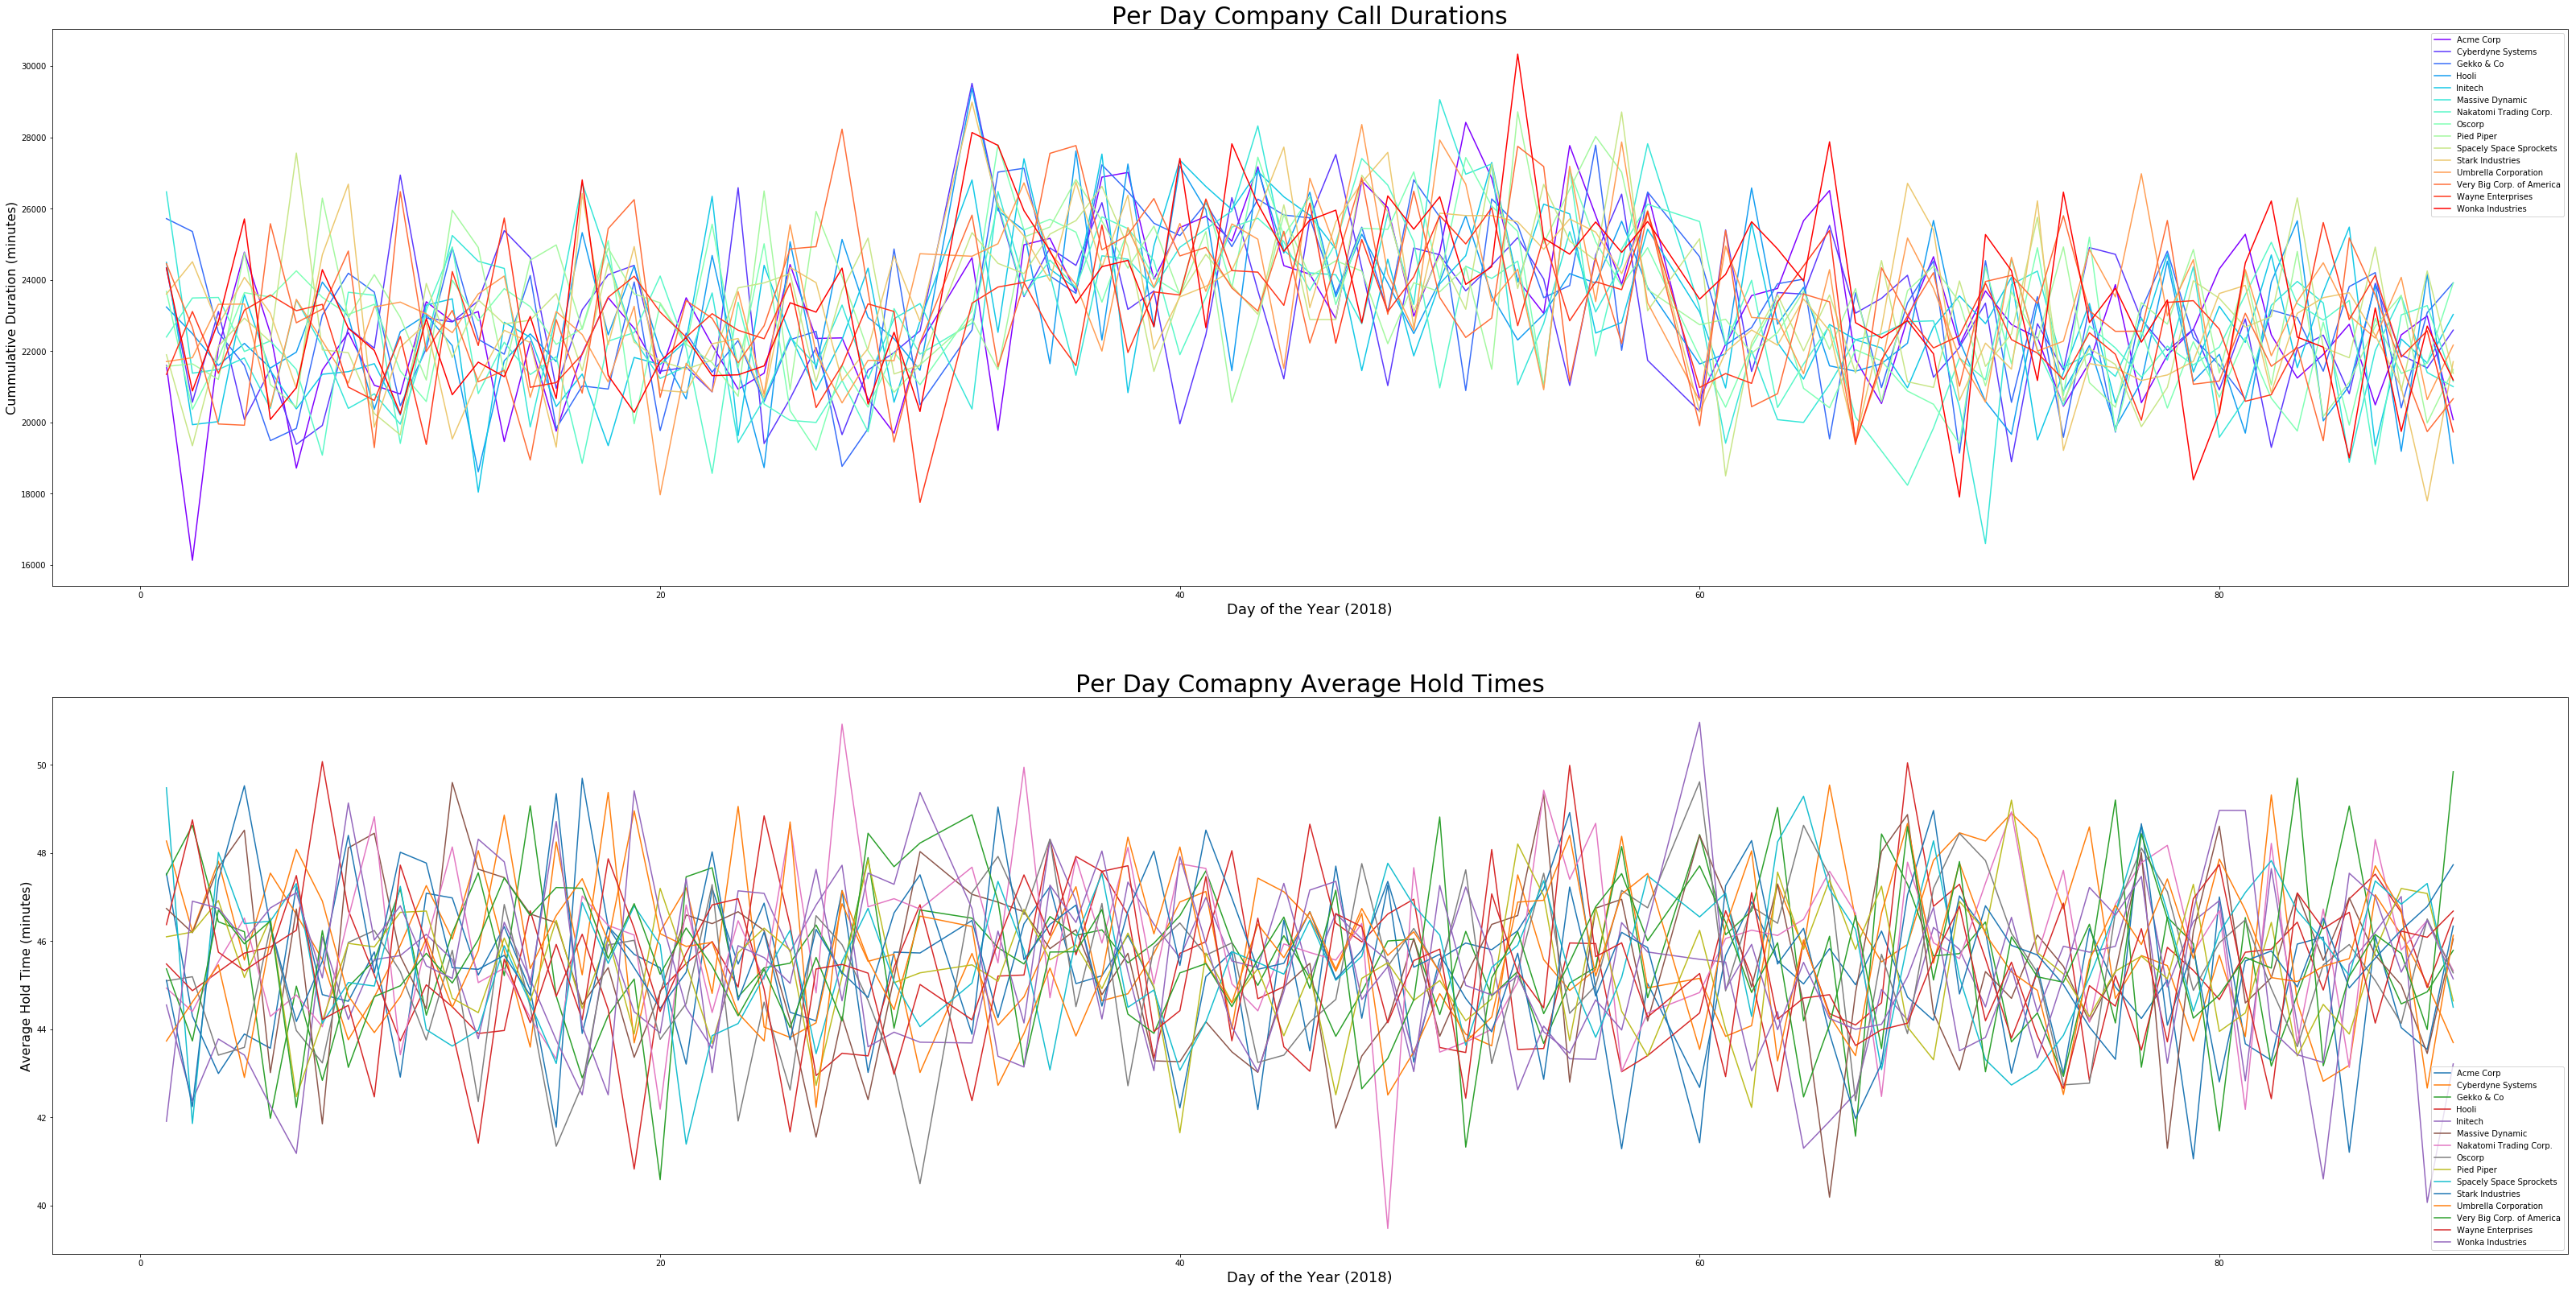

In [18]:
# Generate line plots using the same data to generate the scatter plots to look for intra-company trends:
fig3, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(56, 28))
for company in color_keys:
    per_company_results = results1[results1['Company_Name'] == company]
    color=str(per_company_results['Color'].iloc[0])
    ax1.plot(per_company_results["Day"].dt.dayofyear, per_company_results['Cummulative_Duration'], color=color)
    ax2.plot(per_company_results["Day"].dt.dayofyear, per_company_results['Average_Hold_Time'])


ax1.legend(loc='best', labels=color_keys)
ax1.set_title('Per Day Company Call Durations', fontsize=30)
ax1.set_xlabel('Day of the Year (2018)', fontsize=18)
ax1.set_ylabel('Cummulative Duration (minutes)', fontsize=16)

ax2.legend(loc='best', labels=color_keys)
ax2.set_title('Per Day Comapny Average Hold Times', fontsize=30)
ax2.set_xlabel('Day of the Year (2018)', fontsize=18)
ax2.set_ylabel('Average Hold Time (minutes)', fontsize=16)

Line plots are a mess but it seems like there is a region again at both month transitions where the data behaves differently.
This is likely do to the distorting effect the missing points has at the end of each month.

In [19]:
# create and display heatmap
import seaborn as sns

# need to create a new dataframe of cummulative durations indexed by day
# and each language as it's own column
results2dur = pd.get_dummies(results1['Company_Name'])

# Correlation matrices between lots of features is a mess maybe a heat map will be easier to read:
# create new dataframe where each column represents a language, the values are cummulative_duration, and the index is day
day_keys = results1['Day'].unique()
company_keys = color_keys
company_day_duration = pd.DataFrame(index=day_keys, columns=company_keys)

# allocate values so we can easily produce a correlation heat map from a single dataframe
for company in company_keys:
    for day in day_keys:
        try:
            company_day_duration.loc[day,company] = int(results1[(results1['Day'] == day) & (results1['Company_Name'] == company)]['Cummulative_Duration'])
        except:
            pass

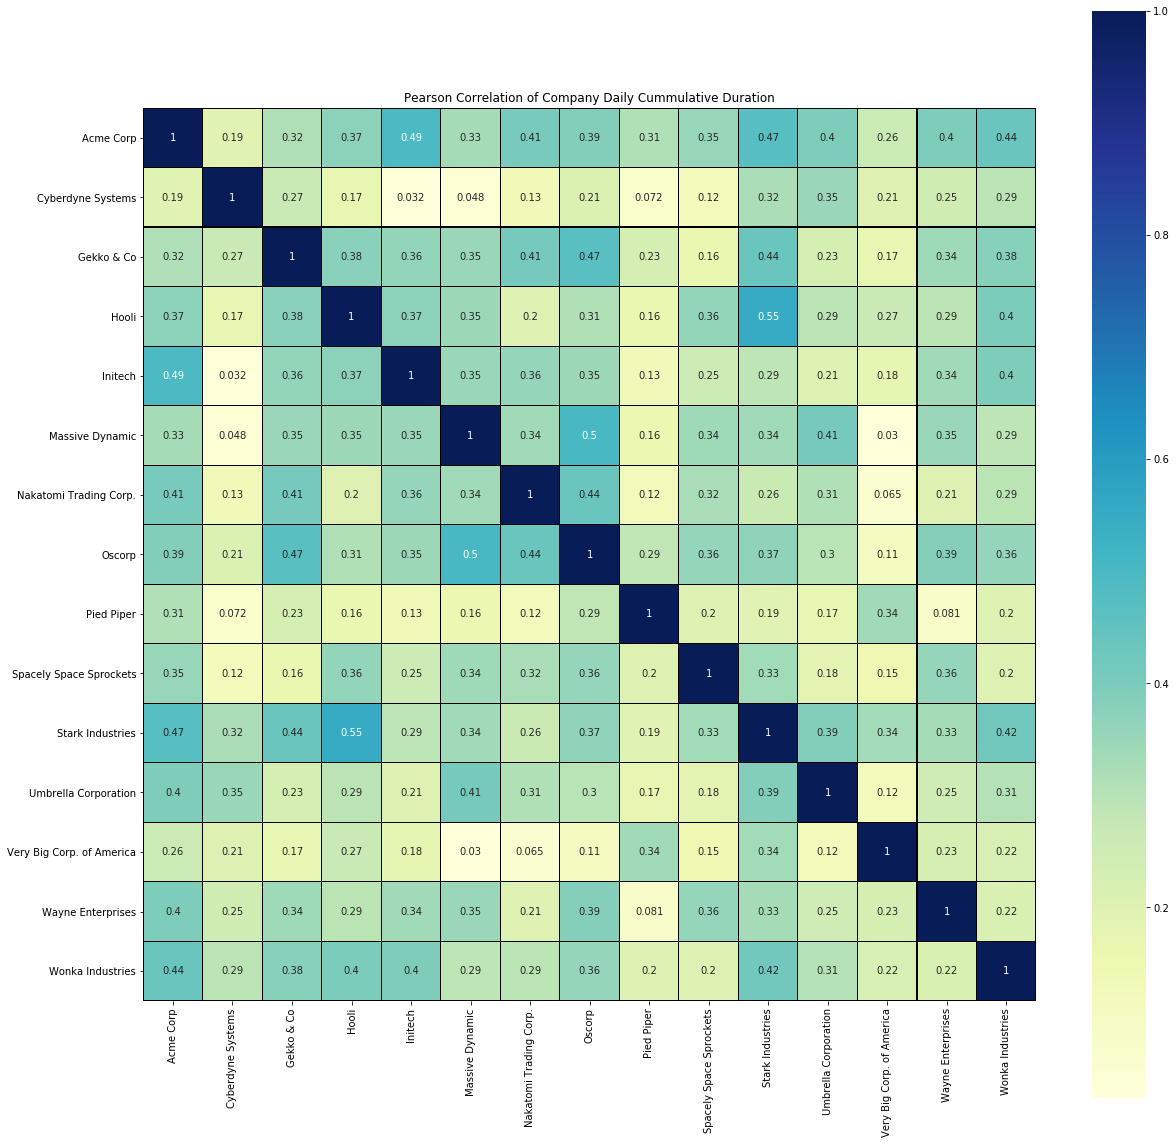

In [20]:
# Set up the figure
fig4, ax = plt.subplots(figsize=(20, 20))
plt.title('Pearson Correlation of Company Daily Cummulative Duration')

# Draw the heatmap using seaborn
sns.heatmap(company_day_duration.corr(),linewidths=0.1, square=True, cmap = "YlGnBu", linecolor='black', annot=True)

In [21]:
# let's filter the correlation matrix for strongest values
company_day_duration.corr()

s = company_day_duration.corr().unstack()
so = s.sort_values(kind="quicksort")

so[:-1*len(company_keys)].tail(10)

Oscorp            Gekko & Co          0.468197
Gekko & Co        Oscorp              0.468197
Stark Industries  Acme Corp           0.471062
Acme Corp         Stark Industries    0.471062
Initech           Acme Corp           0.494064
Acme Corp         Initech             0.494064
Oscorp            Massive Dynamic     0.500331
Massive Dynamic   Oscorp              0.500331
Hooli             Stark Industries    0.549967
Stark Industries  Hooli               0.549967
dtype: float64

Considering all companies have above zero correlation it seems likely that the data is not random and a subset of companies could be used to predict or generalize the global set of company call duration

Visualizations for 3Dii

In [22]:
# Prepare second dataset for ease of use
results2['Average_Hold_Time'] = results2['Average_Hold_Time'].astype(float)
results2["Day"] = pd.to_datetime(results2["Day"]).dt.dayofyear
results2.info()
results2.corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439 entries, 0 to 8438
Data columns (total 4 columns):
Language                8439 non-null object
Cummulative_Duration    8439 non-null int64
Average_Hold_Time       8439 non-null float64
Day                     8439 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 263.8+ KB


,Cummulative_Duration,Average_Hold_Time,Day
Cummulative_Duration,1.000000,0.001305,-0.000069
Average_Hold_Time,0.001305,1.000000,-0.007592
Day,-0.000069,-0.007592,1.000000


In [23]:
# need to create a new dataframe of cummulative durations indexed by day
# and each language as it's own column
results2dur = pd.get_dummies(results2['Language'])

In [24]:
# Correlation matrices between lots of features is a mess maybe a heat map will be easier to read:
# create new dataframe where each column represents a language, the values are cummulative_duration, and the index is day
day_keys = results2['Day'].unique()
language_keys = results2['Language'].unique()
language_day_duration = pd.DataFrame(index=day_keys, columns=language_keys)

In [25]:
# allocate values so we can easily produce a correlation heat map from a single dataframe
for language in language_keys:
    for day in day_keys:
        try:
            language_day_duration.loc[day,language] = int(results2[(results2['Day'] == day) & (results2['Language'] == language)]['Cummulative_Duration'])
        except:
            pass

In [26]:
# computed correlation matrix
language_day_duration.corr()

,Afrikaans,Albanian,Amharic,Arabic,Armenian,Assamese,Aymara,Azeri,Belarusian,Bengali,...,Tamil,Telugu,Tetum,Thai,Tok Pisin,Tsonga,Tswana,West Frisian,Yiddish,Zulu
Afrikaans,1.000000,-0.039303,0.058374,0.139558,-0.101236,0.079524,0.048499,-0.109262,-0.212516,0.020996,...,0.105837,0.083948,0.161365,-0.084796,-0.080707,-0.093166,0.055803,-0.159133,0.252651,0.110482
Albanian,-0.039303,1.000000,0.160771,0.017939,-0.024113,0.048427,0.015404,0.176945,0.113039,0.166005,...,0.347918,0.173273,-0.026281,0.094697,0.136662,0.042996,0.088780,0.151428,-0.075572,-0.020727
Amharic,0.058374,0.160771,1.000000,0.093098,0.112664,-0.006329,0.087400,0.072784,0.038636,0.120411,...,-0.081495,0.097866,0.267502,0.067555,0.027959,-0.025216,-0.063576,0.075011,-0.112253,0.022752
Arabic,0.139558,0.017939,0.093098,1.000000,0.086704,-0.214405,-0.011420,-0.051924,0.028559,0.011134,...,0.023889,0.067994,0.081182,0.058600,0.155365,0.152036,0.163439,0.033406,0.115753,0.114232
Armenian,-0.101236,-0.024113,0.112664,0.086704,1.000000,-0.020917,0.161376,0.108616,0.112720,0.121902,...,-0.177791,-0.021033,-0.093488,0.063943,0.039480,0.142622,0.055207,0.002803,0.155518,-0.160855
Assamese,0.079524,0.048427,-0.006329,-0.214405,-0.020917,1.000000,-0.018950,0.200776,-0.010027,0.117292,...,0.081725,-0.006947,-0.025247,-0.024130,0.129055,-0.023591,-0.024855,0.158653,-0.017984,0.086108
Aymara,0.048499,0.015404,0.087400,-0.011420,0.161376,-0.018950,1.000000,0.118913,0.143236,-0.001320,...,-0.121645,0.055992,0.178506,0.199638,0.034804,0.071271,0.123863,0.085592,-0.020594,0.109844
Azeri,-0.109262,0.176945,0.072784,-0.051924,0.108616,0.200776,0.118913,1.000000,-0.088627,0.263477,...,-0.107509,0.095249,-0.066435,0.201065,0.096493,0.063454,-0.126519,0.295061,0.020042,-0.031360
Belarusian,-0.212516,0.113039,0.038636,0.028559,0.112720,-0.010027,0.143236,-0.088627,1.000000,-0.083525,...,0.119223,0.243909,-0.074288,0.098153,0.016702,0.117589,0.136689,0.038226,-0.056795,0.048730
Bengali,0.020996,0.166005,0.120411,0.011134,0.121902,0.117292,-0.001320,0.263477,-0.083525,1.000000,...,0.187362,0.026239,-0.024811,0.045487,-0.043018,-0.063344,-0.116939,0.097172,0.012046,0.036101


pretty messy let's visualize it...

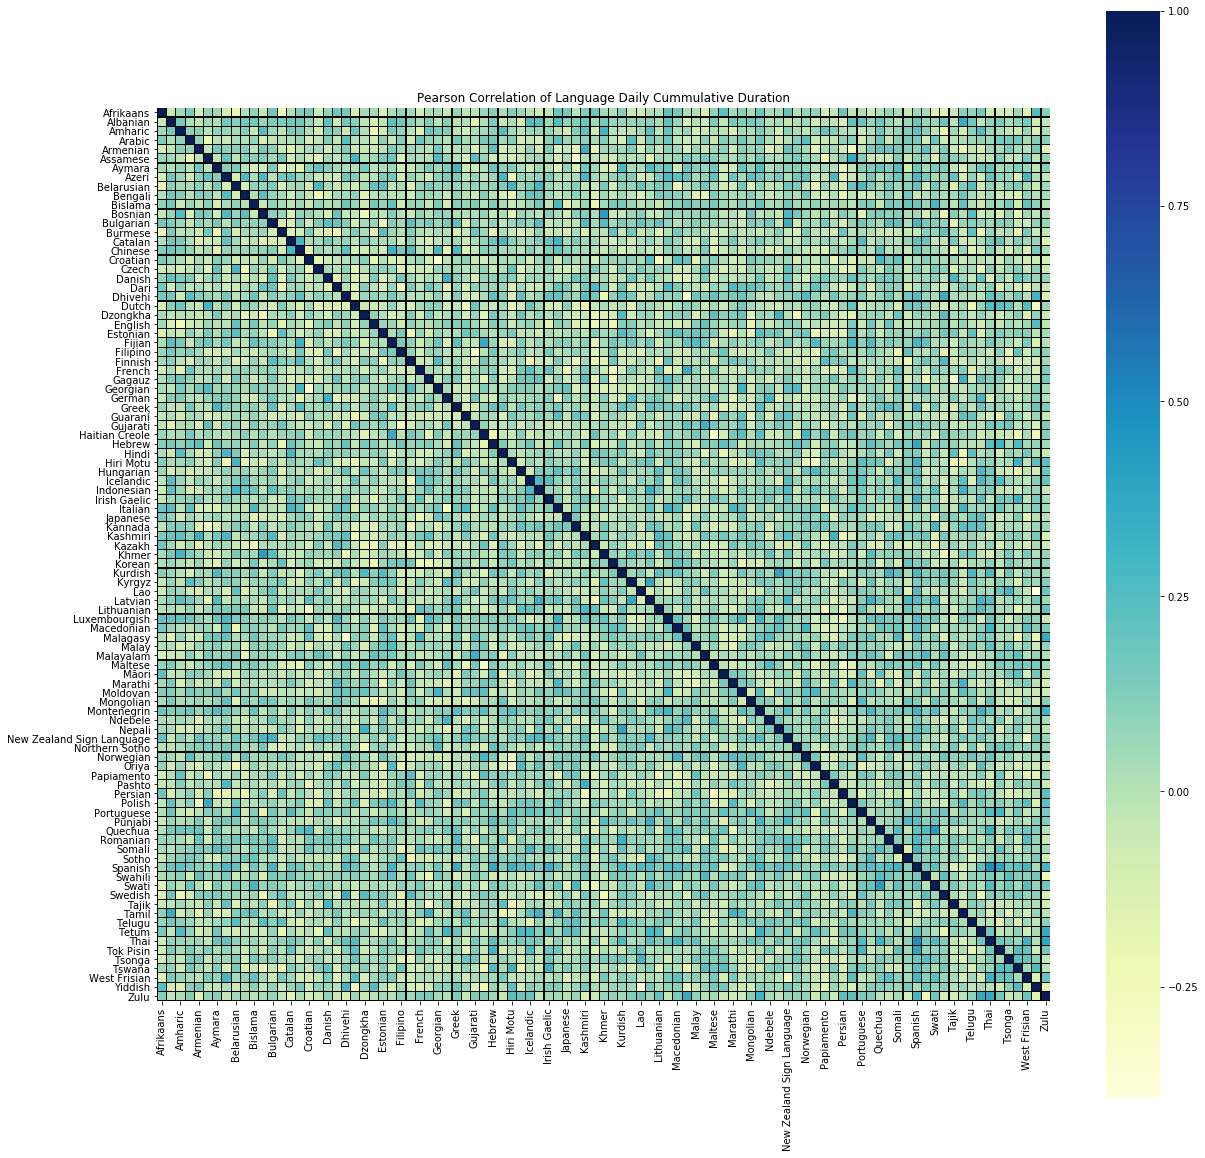

In [32]:
# create and display heatmap
import seaborn as sns

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Pearson Correlation of Language Daily Cummulative Duration')

# Draw the heatmap using seaborn
sns.heatmap(language_day_duration.corr(),linewidths=0.1, square=True, cmap = "YlGnBu", linecolor='black', annot=False)

slightly more readable but still messy

In [28]:
# filter the correlation matrix for strongest values
language_day_duration.corr()

s = language_day_duration.corr().unstack()
so = s.sort_values(kind="quicksort")

In [29]:
# top 5 strongest negative correlations:
so.head(10)

Lao             Yiddish          -0.392301
Yiddish         Lao              -0.392301
Croatian        Georgian         -0.330470
Georgian        Croatian         -0.330470
Tajik           Gagauz           -0.322085
Gagauz          Tajik            -0.322085
Haitian Creole  Maltese          -0.306838
Maltese         Haitian Creole   -0.306838
Kannada         Assamese         -0.306375
Assamese        Kannada          -0.306375
dtype: float64

In [30]:
# top 5 strongest positive correlations:
so[:-97].tail(10)

Kurdish    Nepali       0.389468
Nepali     Kurdish      0.389468
Spanish    Tok Pisin    0.395623
Tok Pisin  Spanish      0.395623
Khmer      Bosnian      0.419683
Bosnian    Khmer        0.419683
Quechua    Swati        0.428646
Swati      Quechua      0.428646
Spanish    Thai         0.481271
Thai       Spanish      0.481271
dtype: float64